<a href="https://colab.research.google.com/github/Ox03bb/Sentiment_Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T233822Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D699489cdd3385459f7884a6f3d8d58122355f8979ee9239d71252c4e2b09596b909e0bcb28261f5973f6ae96f2d075d347b8b19703751d5d74589a0c28f73aee3213b3da64c02bcf26f07de4d76b5283e32700bd540e0faff422d9926144881f396ebb4ad012f6f2b6c502ffabec078a80a2981e15e5b91a88c8b6ffd4ee02351428c885cd3ef9355bdb5db93bcc14c01fb5ba5a644211f533b5c7d09219f3b5c58c38df418ded5e57627a4daf78005b208aa9c2d07c99651ac465c71500164c4cfab1f105f73c700e3e77d5b4b9a28827a3f639b5de691805b535eab662729d910436344f5425cd2eef738648d7009ea1e582b5e196fbf16dabb257aa9b368c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
Data source import complete.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# Packages

In [ ]:
!python -m nltk.downloader all

In [3]:
import nltk
from nltk.tokenize import  word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import corpus
from nltk.tag import pos_tag

import spacy

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from IPython.display import clear_output

import re


# I. Data :

## I.01 Describe :

In [6]:
train_data = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None, names=["Tweet ID", "entity", "sentiment",'Tweet content'])
val_data =  pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",header=None ,names=["Tweet ID", "entity", "sentiment",'Tweet content'])


train_data.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   Tweet content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
train_data.describe(include=['O']).T

,count,unique,top,freq
entity,74682,32,TomClancysRainbowSix,2400
sentiment,74682,4,Negative,22542
Tweet content,73996,69491,"At the same time, despite the fact that there ...",172


<Axes: ylabel='count'>

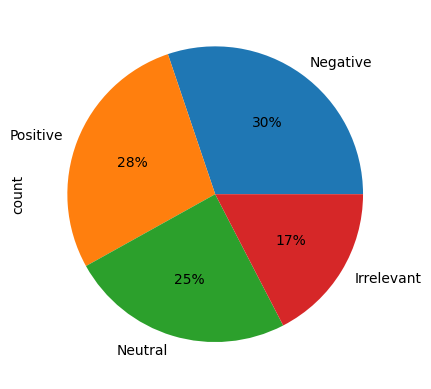

In [9]:
train_data.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

<Axes: xlabel='entity'>

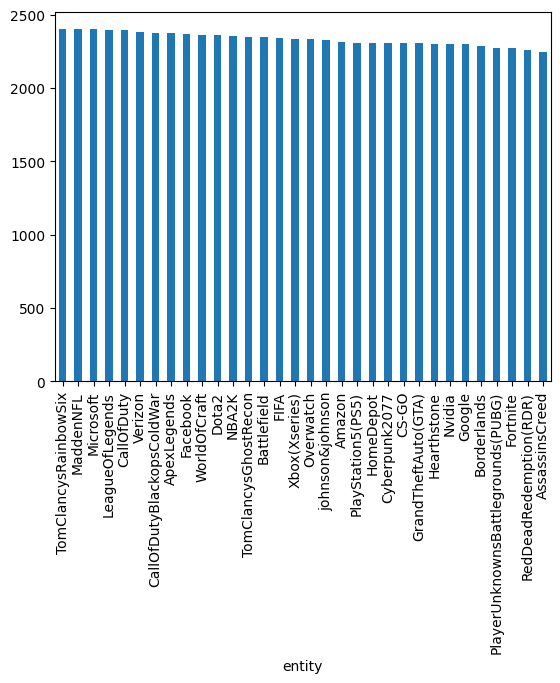

In [10]:
train_data.entity.value_counts().plot(kind='bar')

## I.02 Data Cleaning :

### I.02.a clear nan and Irrelevant :

In [11]:
train_data = train_data.dropna(subset=['Tweet content'])
val_data = val_data.dropna(subset=['Tweet content'])

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [12]:
def del_irr(data):
    id_ = []
    cnt = 0
    for sent in data.sentiment:
        if sent == "Irrelevant":
            id_.append(cnt)
        cnt += 1
    data.drop(id_,inplace=True)

In [13]:
del_irr(train_data)
del_irr(val_data)

In [14]:
# to fix concatinat problem

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [15]:
len(train_data)

61121

In [16]:
train_data.sentiment.value_counts()

sentiment
Negative    22358
Positive    20655
Neutral     18108
Name: count, dtype: int64

### I.02.b Drop 'Tweet ID'  :

In [17]:
train_data = train_data.drop('Tweet ID',axis=1)
val_data = val_data.drop('Tweet ID',axis=1)

In [18]:
train_data

,entity,sentiment,Tweet content
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...
61116,Nvidia,Positive,Just realized that the Windows partition of my...
61117,Nvidia,Positive,Just realized that my Mac window partition is ...
61118,Nvidia,Positive,Just realized the windows partition of my Mac ...
61119,Nvidia,Positive,Just realized between the windows partition of...


## I.03 Data Encodeing

In [19]:
s = np.array(train_data.sentiment.values).reshape(-1,1)
s2 = np.array(val_data.sentiment.values).reshape(-1,1)

In [20]:
OHE_sent = OneHotEncoder()
OHE_sent_fit = OHE_sent.fit(s)
encoded_train = OHE_sent.transform(s).toarray()
encoded_val = OHE_sent.transform(s2).toarray()

In [21]:
OHE_sent_fit.categories_

[array(['Negative', 'Neutral', 'Positive'], dtype=object)]

In [22]:
y_train = pd.DataFrame(encoded_train,columns=['Negative', 'Neutral', 'Positive'])
y_val =pd.DataFrame(encoded_val,columns=['Negative', 'Neutral', 'Positive'])

In [23]:
len(y_train),len(train_data)

(61121, 61121)

In [24]:
train_data_ = train_data.drop("sentiment",axis=1)
val_data_ = val_data.drop("sentiment",axis=1)

In [25]:
train_data_.head(2)

,entity,Tweet content
0,Borderlands,im getting on borderlands and i will murder yo...
1,Borderlands,I am coming to the borders and I will kill you...


In [26]:
OHE_entity = OneHotEncoder()
OHE_entity_fit = OHE_entity.fit(np.array(train_data_.entity).reshape(-1,1))
encoded_train = OHE_entity.transform(np.array(train_data_.entity).reshape(-1,1)).toarray()
encoded_val = OHE_entity.transform(np.array(val_data_.entity).reshape(-1,1)).toarray()

In [27]:
df_encoded_train = pd.DataFrame(encoded_train,columns=OHE_entity_fit.categories_[0])
df_encoded_val =pd.DataFrame(encoded_val,columns=OHE_entity_fit.categories_[0])

In [28]:
train_data_ = pd.concat([train_data_,df_encoded_train], axis=1)
val_data_ = pd.concat([val_data_,df_encoded_val ], axis=1)

In [29]:
train_data_.head(2)

,entity,Tweet content,Amazon,ApexLegends,AssassinsCreed,Battlefield,Borderlands,CS-GO,CallOfDuty,CallOfDutyBlackopsColdWar,...,Overwatch,PlayStation5(PS5),PlayerUnknownsBattlegrounds(PUBG),RedDeadRedemption(RDR),TomClancysGhostRecon,TomClancysRainbowSix,Verizon,WorldOfCraft,Xbox(Xseries),johnson&johnson
0,Borderlands,im getting on borderlands and i will murder yo...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Borderlands,I am coming to the borders and I will kill you...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_data_ = train_data_.drop("entity",axis=1)
val_data_ = val_data_.drop("entity",axis=1)

In [31]:
train_data_.head(2)

,Tweet content,Amazon,ApexLegends,AssassinsCreed,Battlefield,Borderlands,CS-GO,CallOfDuty,CallOfDutyBlackopsColdWar,Cyberpunk2077,...,Overwatch,PlayStation5(PS5),PlayerUnknownsBattlegrounds(PUBG),RedDeadRedemption(RDR),TomClancysGhostRecon,TomClancysRainbowSix,Verizon,WorldOfCraft,Xbox(Xseries),johnson&johnson
0,im getting on borderlands and i will murder yo...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I am coming to the borders and I will kill you...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## I.02 Tweet content :

### I.02.a Tokenization :

In [32]:
len(train_data_)

61121

In [33]:
def token(data,col):
    tokenized = []
    cnt = 0
    for sent in data[col]:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        tokenized.append(word_tokenize(sent))
        cnt += 1
    return tokenized

In [34]:
train_data_01 = token(train_data_,"Tweet content")
val_data_01   = token(val_data_,"Tweet content")

72.46376811594203


### I.02.b Ponctoation  :

In [35]:
ponc = "\"#%&'()*+, -./:;<=>@[\]^_`{|}~   ...  ’'''“.``¤`"

def del_ponc(data):
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        sub_list = []
        for word in sent:
            if word not in ponc:
                sub_list.append(word)
        lists.append(sub_list)
        cnt += 1
    return lists

In [36]:
train_data_02 = del_ponc(train_data_01)
val_data_02   = del_ponc(val_data_01)

72.46376811594203


In [37]:
print(train_data_02[:3])

[['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'murder', 'you', 'all'], ['I', 'am', 'coming', 'to', 'the', 'borders', 'and', 'I', 'will', 'kill', 'you', 'all'], ['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'kill', 'you', 'all']]


### I.02.c Lower  :

In [38]:
def lower(data):
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        sub_list = []
        for word in sent:
            sub_list.append(word.lower())
        lists.append(sub_list)
        cnt += 1
    return lists

In [39]:
train_data_03 = lower(train_data_02)
val_data_03   = lower(val_data_02)

72.46376811594203


In [40]:
print(train_data_03[:3])

[['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'murder', 'you', 'all'], ['i', 'am', 'coming', 'to', 'the', 'borders', 'and', 'i', 'will', 'kill', 'you', 'all'], ['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'kill', 'you', 'all']]


### I.02.d del_links  :

In [41]:
pattern = r'[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'

def del_links(data,patt):
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        sub_list = []
        for word in sent:
            if not re.search(patt,word):
                sub_list.append(word)
        lists.append(sub_list)
        cnt += 1
    return lists

In [42]:
train_data_04 = del_links(train_data_03,pattern)
val_data_04   = del_links(val_data_03,pattern)

72.46376811594203


In [43]:
print(val_data_04[:3])

[['bbc', 'news', 'amazon', 'boss', 'jeff', 'bezos', 'rejects', 'claims', 'company', 'acted', 'like', 'a', "'drug", 'dealer'], ['microsoft', 'why', 'do', 'i', 'pay', 'for', 'word', 'when', 'it', 'functions', 'so', 'poorly', 'on', 'my', 'samsungus', 'chromebook', '?', '🙄'], ['csgo', 'matchmaking', 'is', 'so', 'full', 'of', 'closet', 'hacking', 'it', "'s", 'a', 'truly', 'awful', 'game']]


### I.02.e del_Stop_words :

In [44]:
stop_word = stopwords.words('english')

In [45]:
added_sw = ["im","n't","'m","'s","e"]
for i in added_sw:
    stop_word.append(i)

In [46]:
def del_stop_word(data):
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        sub_list = []
        for word in sent:
            if word not in stop_word:
                sub_list.append(word)
        lists.append(sub_list)
        cnt += 1
    return lists

In [47]:
train_data_05 = del_stop_word(train_data_04)
val_data_05   = del_stop_word(val_data_04)

72.46376811594203


### I.02.f lemitizing :

In [50]:
def lemmatizeing(data):
    lemmatizer = WordNetLemmatizer()
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%600:
            clear_output(wait=True)
            print(cnt*100/len(data))
        sub_list = []
        for word in sent:
            if word.isalpha():
                tag = pos_tag(list(word))[0][1]
                if tag.startswith('NN'):
                    pos = 'n'
                elif tag.startswith('VB'):
                    pos = 'v'
                else:
                    pos = 'a'
                sub_list.append(lemmatizer.lemmatize(word, pos))
            else:
                sub_list.append(word)
        lists.append(sub_list)
        cnt += 1
    return lists

In [51]:
train_data_06 = lemmatizeing(train_data_05)
val_data_06   = lemmatizeing(val_data_05)

72.46376811594203


### I.02.g Empty elemnts :

In [ ]:
def empty_sent_id(data):
    id_ = []
    lists = []
    cnt = 0
    for sent in data:
        if not cnt%300:
            clear_output(wait=True)
            print(cnt*100/len(data))
        if len(sent) == 0:
            id_.append(cnt)
        else:
            lists.append(sent)
        cnt += 1
    return id_,lists

In [ ]:
id_t,train_data_07 = del_stop_word(train_data_06)
id_v,val_data_07   = del_stop_word(val_data_06)